In [1]:
import pandas as pd
import numpy as np
import nltk
import os

In [2]:
import os
number_of_files = 1000
base_dir = 'data/labels/'
ext = '.xlsx'
df = pd.DataFrame()
for file_name in os.listdir(base_dir):
    if number_of_files < 0: break
    if not file_name.endswith(ext): continue
    number_of_files -= 1
    print('reading files', file_name)
    df = df.append(pd.read_excel(base_dir + file_name))

reading files data_for_labelling4.xlsx
reading files data_for_labelling8.xlsx
reading files data_for_labelling9.xlsx
reading files data_for_labelling5.xlsx
reading files data_for_labelling3.xlsx
reading files data_for_labelling2.csv.xlsx
reading files data_for_labelling6 (1) (1).xlsx
reading files data_for_labelling1.csv.xlsx
reading files data_for_labelling0.csv.xlsx
reading files data_for_labelling7.xlsx


In [3]:
df.dtypes

% nans             float64
Attribute_name      object
Check               object
Num of nans          int64
Reason              object
Record_id            int64
Total_val            int64
Unnamed: 2          object
Unnamed: 9         float64
check               object
max_val            float64
mean               float64
min_val            float64
num of dist_val      int64
reason              object
sample_1            object
sample_2            object
sample_3            object
sample_4            object
sample_5            object
std_dev            float64
y_Arun              object
y_act               object
y_pred              object
dtype: object

In [4]:
cols = df.columns.tolist()
print(cols)

['% nans', 'Attribute_name', 'Check', 'Num of nans', 'Reason', 'Record_id', 'Total_val', 'Unnamed: 2', 'Unnamed: 9', 'check', 'max_val', 'mean', 'min_val', 'num of dist_val', 'reason', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5', 'std_dev', 'y_Arun', 'y_act', 'y_pred']


In [5]:
cols = ['y_act','Reason','Attribute_name','Total_val','num of dist_val','% nans'] + cols[10:13] + ['std_dev'] + cols[15:-4]

In [6]:
df = df.reindex(columns=cols)
df[:1]

,y_act,Reason,Attribute_name,Total_val,num of dist_val,% nans,max_val,mean,min_val,std_dev,sample_1,sample_2,sample_3,sample_4,sample_5
0,Unusable,l,StratificationCategory2,403984,1,80.364816,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [7]:
print(df.columns.tolist())

['y_act', 'Reason', 'Attribute_name', 'Total_val', 'num of dist_val', '% nans', 'max_val', 'mean', 'min_val', 'std_dev', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']


In [8]:
df.y_act.unique()

array(['Unusable', 'Usable with extraction',
       'Usable directly categorical', 'Context_specific',
       'Usable directly numeric', 'Usable Directly Numeric',
       'Usable Directly Categorical', 'Usable with Extraction',
       'Usable Directly Categorical ', 'Usable with Extration',
       'Usable With Extraction', 'Usable with Extraction ', 'unusable',
       'Usable Directly numeric', 'Usable directly Categorical',
       'Usable Directly categorical'], dtype=object)

In [9]:
def label_mapper(row):
    x = row['y_act']
    try:
        if 'categorical' in x.lower():
            return 'Usable Directly Categorical'
        if 'numeric' in x.lower():
            return 'Usable Directly Numeric'
        if 'extra' in x.lower():
            return 'Usable With Extraction'
        if 'unusable' in x.lower():
            return 'Unusable'
        if 'context' in x.lower():
            return 'Context_Specific'
    except:
        print(x)
        return 'NaN'

In [10]:
df['y_act'] = df.apply(lambda row: label_mapper(row), axis=1)

In [11]:
categories = {'Usable Directly Categorical':1, 'Usable Directly Numeric':2, 'Usable With Extraction':3, 'Unusable':4, 'Context_Specific':5, 'None':0}

In [12]:
categories_size = {'Context_Specific':2050,'Unusable':891,'Usable Directly Categorical':2087,'Usable Directly Numeric':5063,'Usable With Extraction':650}

In [13]:
df.groupby(df.y_act).size()

y_act
Context_Specific               2050
Unusable                        891
Usable Directly Categorical    2087
Usable Directly Numeric        5063
Usable With Extraction          650
dtype: int64

In [14]:
from lfs.helper import *
from lfs.lf_categorical import *
from lfs.lf_extration import *
from lfs.lf_numerical import *
from lfs.lf_unusable import *
from lfs.lf_mixed_class import *

## LABELING FUNCTIONS

In [15]:
lfs_ext = [lf_extractable_units, lf_extractable_number_sci, lf_extractable_pattern, lf_date_extraction_name, lf_extractable_name, lf_extractable_list, lf_extractable_sample_length, lf_date_extraction_samples, lf_extractable_email_url]
lfs_cate = [lf_binary_category, lf_name_category, lf_coded_abbreviation, lf_finite_set_name, lf_finite_set_sample, lf_dist_string_percentage, lf_dist_num_percentage]
lfs_num = [lf_cast_to_numbers]
lfs_unusable = [lf_unusable, lf_unusable_nans]
lfs_mixed = [lf_key_word_year]

In [16]:
LFs_1 = lfs_unusable
LFs_2 = lfs_ext + lfs_cate + lfs_num + lfs_mixed
LFs_3 = []
LFs = LFs_1+LFs_2+LFs_3

In [17]:
total_lfs = len(LFs_1)+len(LFs_2)+len(LFs_3)
total_lfs

20

In [18]:
n, m = len(df), total_lfs+1
n, m

(10741, 21)

In [19]:
Ls = np.zeros((n,m))
j = -1
flag_1 = [False] * n
cnt = 0
for lf in LFs_1:
    i = -1
    j += 1
    for index, row in df.iterrows():
        i += 1
        Ls[i][j] = lf(row)
        if Ls[i][j] != 0:
            flag_1[i] = True

flag_2 = flag_1.copy()
for lf in LFs_2:
    i = -1
    j += 1
    for index, row in df.iterrows():
        i += 1
        if not flag_1[i]:
            Ls[i][j] = lf(row)
        if Ls[i][j] != 0:
            flag_2[i] = True

flag_3 = flag_2.copy()
for lf in LFs_3:
    i = -1
    j += 1
    for index, row in df.iterrows():
        i += 1
        if not flag_2[i]:
            Ls[i][j] = lf(row)
        if Ls[i][j] != 0:
            flag_3[i] = True
            
j+=1
for i in np.where(np.array(flag_3)==False)[0]:
    Ls[i][j] = 5

In [20]:
df.groupby(df.y_act).size()

y_act
Context_Specific               2050
Unusable                        891
Usable Directly Categorical    2087
Usable Directly Numeric        5063
Usable With Extraction          650
dtype: int64

In [21]:
np.unique(Ls, return_counts=True)

(array([0., 1., 2., 3., 4., 5.]),
 array([210200,   4700,   7521,   1328,   1708,    104]))

In [24]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [25]:
from scipy.sparse import csr_matrix

In [26]:
L_train = csr_matrix(np.array(Ls, dtype=int))
L_train

<10741x21 sparse matrix of type '<class 'numpy.int64'>'
	with 15361 stored elements in Compressed Sparse Row format>

In [27]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 5


In [28]:
gen_model.weights.lf_accuracy

array([0.73524946, 0.72803433, 0.70504515, 0.7056207 , 0.70880496,
       0.71043474, 0.70671161, 0.70731808, 0.706857  , 0.71255884,
       0.70829756, 0.75268201, 0.72855988, 0.71683649, 0.73482953,
       0.72325783, 0.75407547, 0.72557598, 0.63258521, 0.70364665,
       0.70481322])

In [29]:
train_marginals = gen_model.marginals(L_train)

In [30]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [31]:
gen_model.learned_lf_stats()

,Accuracy,Coverage
0,0.514224,0.80144
1,0.518775,0.80212
2,0.507591,0.80096
3,0.494952,0.80032
4,0.507795,0.80056
5,0.513588,0.80072
6,0.505219,0.79712
7,0.513527,0.79692
8,0.506232,0.80232
9,0.508126,0.79988


In [32]:
train_marginals

array([[0.04412389, 0.04412389, 0.04412389, 0.82350444, 0.04412389],
       [0.04412389, 0.04412389, 0.04412389, 0.82350444, 0.04412389],
       [0.04412389, 0.04412389, 0.04412389, 0.82350444, 0.04412389],
       ...,
       [0.132561  , 0.46975598, 0.132561  , 0.132561  , 0.132561  ],
       [0.132561  , 0.46975598, 0.132561  , 0.132561  , 0.132561  ],
       [0.132561  , 0.46975598, 0.132561  , 0.132561  , 0.132561  ]])

In [39]:
np.savetxt('train_marginals.txt', train_marginals)

In [40]:
df.to_csv('train_raw.csv')

In [33]:
denoised_labels = np.argmax(train_marginals, axis=1)
denoised_labels[:50]

array([3, 3, 3, 3, 2, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 2, 0, 0, 0, 0, 2,
       2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 1, 4, 1, 0, 0, 1, 0, 0, 0,
       0, 2, 0, 0, 0, 0])

In [34]:
corrects = 0
cm = np.zeros(5)
i = -1
for index, row in df.iterrows():
    i += 1
    if denoised_labels[i]+1 == categories[row.y_act]:
        corrects += 1
    else:
        cm[categories[row.y_act]-1] += 1

In [35]:
corrects / len(df)

0.6894143934456755

In [36]:
corrects

7405

In [37]:
cm

array([ 335.,  674.,  287.,   35., 2005.])

BACKUP

In [85]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [98]:
from scipy.sparse import csr_matrix

In [99]:
L_train = csr_matrix(np.array(Ls, dtype=int))
L_train

<10741x17 sparse matrix of type '<class 'numpy.int64'>'
	with 11999 stored elements in Compressed Sparse Row format>

In [100]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 5


In [101]:
gen_model.weights.lf_accuracy

array([0.71233108, 0.70567372, 0.70536448, 0.70789609, 0.70711461,
       0.70982874, 0.70698972, 0.70794799, 0.70350743, 0.72981279,
       0.72691405, 0.71446542, 0.72066986, 0.74939244, 0.72188569,
       0.81458312, 0.70733583])

In [102]:
train_marginals = gen_model.marginals(L_train)

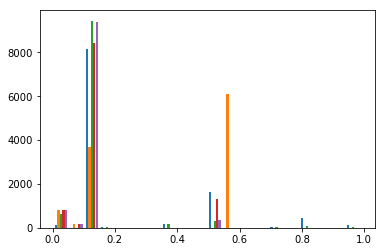

In [103]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [104]:
gen_model.learned_lf_stats()

,Accuracy,Coverage
0,0.510354,0.79968
1,0.503390,0.79652
2,0.504969,0.79688
3,0.503832,0.79852
4,0.507562,0.79612
5,0.508077,0.79736
6,0.510088,0.79696
7,0.505249,0.80016
8,0.498974,0.79932
9,0.519279,0.79880


In [107]:
train_marginals

array([[0.12260231, 0.12260231, 0.12260231, 0.50959077, 0.12260231],
       [0.12260231, 0.12260231, 0.12260231, 0.50959077, 0.12260231],
       [0.12260231, 0.12260231, 0.12260231, 0.50959077, 0.12260231],
       ...,
       [0.10989469, 0.56042125, 0.10989469, 0.10989469, 0.10989469],
       [0.10989469, 0.56042125, 0.10989469, 0.10989469, 0.10989469],
       [0.10989469, 0.56042125, 0.10989469, 0.10989469, 0.10989469]])

In [124]:
denoised_labels = np.argmax(train_marginals, axis=1)
denoised_labels[:50]

array([3, 3, 3, 3, 2, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 2, 0, 0, 0, 0, 2,
       0, 2, 0, 4, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 4, 1, 0, 0, 1, 0, 0, 0,
       4, 2, 0, 0, 0, 0])

In [126]:
corrects = 0
cm = np.zeros(5)
i = -1
for index, row in df.iterrows():
    i += 1
    if denoised_labels[i]+1 == categories[row.y_act]:
        corrects += 1
    else:
        cm[categories[row.y_act]-1] += 1

In [127]:
corrects / len(df)

0.6813145889581975

In [128]:
corrects

7318

In [129]:
cm

array([ 530.,  535.,  317.,  105., 1936.])